# Ego4D - NLQ Benchmark


## Task
Natural Language Queries (NLQ) is a task in the Ego4D Episodic Memory Benchmark. The motivation behind the NLQ task is to enable searching through an egocentric video using a natural language query. The system responds to a query by providing a temporal window localized in the video, from which the answer to the query can be deduced. More concretely, given an egocentric video V and a natural language query Q, the goal is to identify a response track r, such that the answer to Q can be deduced from r. The response track should be a set of temporally continguous frames within V.

## Data
- Input: Long, untrimmed video clip V and a natural language query Q
- Output: Temporally contiguous set of frames r within V, such that the answer to Q can be deduced from r



## Code

### **Download Data and Setup Environment**

#### Fill In Your Access Info Here
If you don't have access and secret keys, first sign the Ego4D License at [ego4ddataset.com](https://ego4ddataset.com)

In [1]:
import os
os.environ['AWS_ACCESS_KEY_ID'] = 'insert here your access key ID'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'insert here your secret access key'

#### Set up CLIs and Download Annotations + Repo

In [2]:
# Download the AWS and Ego4D CLIs, then download the annotations locally
%%bash

# Set up the AWS CLI
curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
unzip -o awscliv2.zip >/dev/null
sudo ./aws/install >/dev/null 2>&1
aws configure set aws_access_key_id "$AWS_ACCESS_KEY_ID" && aws configure set aws_secret_access_key "$AWS_SECRET_ACCESS_KEY"
rm "awscliv2.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64.2M  100 64.2M    0     0   199M      0 --:--:-- --:--:-- --:--:--  199M


#### Install the ego4d CLI and Download Data

In [3]:
# Set up the Ego4D CLI
!pip install ego4d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.3 MB/s eta 0:00:00
  Created wheel for ego4d: filename=ego4d-1.7.3-py3-none-any.whl size=118254 sha256=7a45bf32c2180ed0051c31b9b6ed5cdc5b2837fe71503991689f1f10823d4557
  Stored in directory: /root/.cache/pip/wheels/65/a8/89/a6187e3bc9a85e81899ab8d5ddc2011c9954d3b6cb84d47e03
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=23f00a4

In [4]:
# Download the Ego4D Annotations to ego4d_data/v1/annotations
!ego4d --output_directory="/content/ego4d_data/" --datasets annotations --benchmarks nlq -y --version v1

Datasets to download: {'annotations'}
Download Path: /content/ego4d_data/v1
Ego4D Metadata: /content/ego4d_data/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'annotations' at: /content/ego4d_data/v1/annotations
Benchmarks specified but ignored without a benchmarks field in manifest.
Retrieving object metadata from S3...
100% 31/31 [00:00<00:00, 696.60object/s]
Checking if latest file versions are already downloaded...
 32% 10/31 [00:00<00:00, 30.68file/s]WARNING:urllib3.connectionpool:Connection pool is full, discarding connection: ego4d-consortium-sharing.s3.us-west-1.amazonaws.com. Connection pool size: 10
100% 31/31 [00:00<00:00, 86.09file/s]
No existing videos to filter.
 99% 2.48G/2.51G [00:25<00:00, 244MiB/s]Checking file integrity...
100% 2.51G/2.51G [00:25<00:00, 107MiB/s]


### **Analysis and plots of the train annotations**


In [ ]:
#Analysis and plots imports
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

In [ ]:
# Load JSON data
ego4d_data = json.load(open("/content/ego4d_data/ego4d.json"))
nlq_data = json.load(open("/content/ego4d_data/v1/annotations/nlq_train.json"))

# Initialize variables for analysis
template_distribution = {}
clip_durations = []
answer_durations = []
answer_start_positions = []
answer_end_positions = []



# Create a mapping of video_uid to scenarios
video_to_scenarios = {}
for video in ego4d_data["videos"]:
    video_to_scenarios[video["video_uid"]] = video.get("scenarios", [])

# Initialize a dictionary to hold scenario to query count
scenario_query_counts = defaultdict(int)
scenario_durations = defaultdict(list)
# Initialize a nested dictionary to store template counts by scenario
scenario_template_counts = defaultdict(lambda: defaultdict(int))



for video in nlq_data["videos"]:
    video_uid = video["video_uid"]
    scenarios = video_to_scenarios.get(video_uid, [])
    for clip in video["clips"]:
        clip_start = clip["video_start_sec"]
        clip_end = clip["video_end_sec"]
        clip_duration = clip_end - clip_start  # Duration of this clip

        if clip_duration <= 0:
            continue  # Skip invalid clips

        for annotation in clip["annotations"]:
            for query in annotation["language_queries"]:
                # Analyze template distribution
                template = query.get("template", "None")
                if template is None or pd.isna(template):  # Check for None or NaN
                    template = "None"
                template_distribution[str(template)] = template_distribution.get(str(template), 0) + 1

                # Calculate clip duration
                clip_durations.append(clip_duration)

                # Calculate answer segment duration and normalized positions
                answer_start = query["video_start_sec"]
                answer_end = query["video_end_sec"]
                # Answer duration
                answer_duration = answer_end - answer_start
                answer_durations.append(answer_duration)
                # Normalize positions within the clip --> they reveal where answers are placed w.r.t. the clip (i.e. at the beginning, in the middle etc.)
                normalized_start = (answer_start - clip_start) / clip_duration
                normalized_end = (answer_end - clip_start) / clip_duration
                '''
                Example to understand normalized position of start and end clip w.r.t. the entire clip duration:

                clip_start = 2s
                clip_end = 10s
                answer_start = 4s
                answer_end = 8s

                clip_duration = 10 - 2 = 8 seconds

                normalized_start = (4 - 2) / 8 = 0.25
                normalized_end = (8 - 2) / 8 = 0.75

                Interpretation:
                - The answer segment starts at 0.25 (1/4th) and ends at 0.75 (3/4th) of the clip duration.
                '''
                # Append normalized positions
                answer_start_positions.append(normalized_start)
                answer_end_positions.append(normalized_end)

                # Process scenarios
                for scenario in scenarios:
                    # If the scenario string is too long, split it roughly into two lines
                    if len(scenario) > 80:
                        midpoint = len(scenario) // 2
                        # Find a space near the midpoint to split the string for better readability
                        split_point = scenario.rfind(" ", 0, midpoint)
                        if split_point == -1:  # If no space is found, split exactly at the midpoint
                            split_point = midpoint
                        scenario = scenario[:split_point] + "\n" + scenario[split_point:].strip()

                    scenario_query_counts[scenario] += 1 # Increment query count for all associated scenarios
                    scenario_durations[scenario].append(answer_duration) # Collect answer durations for statistical analysis
                    scenario_template_counts[scenario][template] += 1 # Map NLQ templates to scenarios


### Summary of Plots and Analysis

#### 1. Template Distribution
- **Description:** Visualizes the frequency of queries categorized by their templates.
- **Plot Type:** Bar chart.

#### 2. Clip Duration Distribution (+ Stats)
- **Description:** Displays the distribution of input clip durations.
- **Additional Insights:** Includes statistical metrics such as:
  - Mean, median, standard deviation, minimum and maximum durations.
- **Plot Type:** Histogram.

#### 3. Answer Segment Duration Distribution (+ Stats)
- **Description:** Shows the distribution of durations for answer segments.
- **Additional Insights:** Provides descriptive statistics:
  - Mean, median, standard deviation, minimum and maximum durations.
- **Plot Type:** Histogram.

#### 4. Answer vs. Clip Durations
- **Description:** Highlights the relationship between clip durations and the durations of their respective answer segments.
- **Plot Type:** Scatter plot.

#### 5. Average Answer Duration by Template
- **Description:** Visualizes the average durations of answer segments grouped by template type.
- **Plot Type:** Bar chart.

#### 6. Relative Position of Answer Start and End
- **Description:** Plots the normalized start and end positions of answer segments relative to their respective clips.
- **Plot Type:** Scatter plot.

#### 7. Answer Start and End (along the Clip) Distribution
- **Description:** Illustrates the distributions of normalized start and end timestamps of answer segments.
- **Plot Type:** Overlapping histograms.

##### 8. Number of Queries per Scenario (+ Stats)
- **Description:** Depicts the number of queries across different scenarios.
- **Additional Insights:** Includes statistical metrics such as:
  - Mean, median, standard deviation, minimum and maximum counts.
- **Plot Type:** Horizontal bar chart.

#### 9. Average Answer Durations per Scenario (+ Stats)
- **Description:** Highlights the average durations of answer segments for each scenario.
- **Additional Insights:** Provides statistics:
  - Mean, median, standard deviation, minimum and maximum durations.
- **Plot Type:** Horizontal bar chart.

#### 10. Query Template Distribution Across Scenarios
- **Description:** Illustrates the frequency distribution of query templates across different scenarios.
- **Plot Type:** Heatmap.


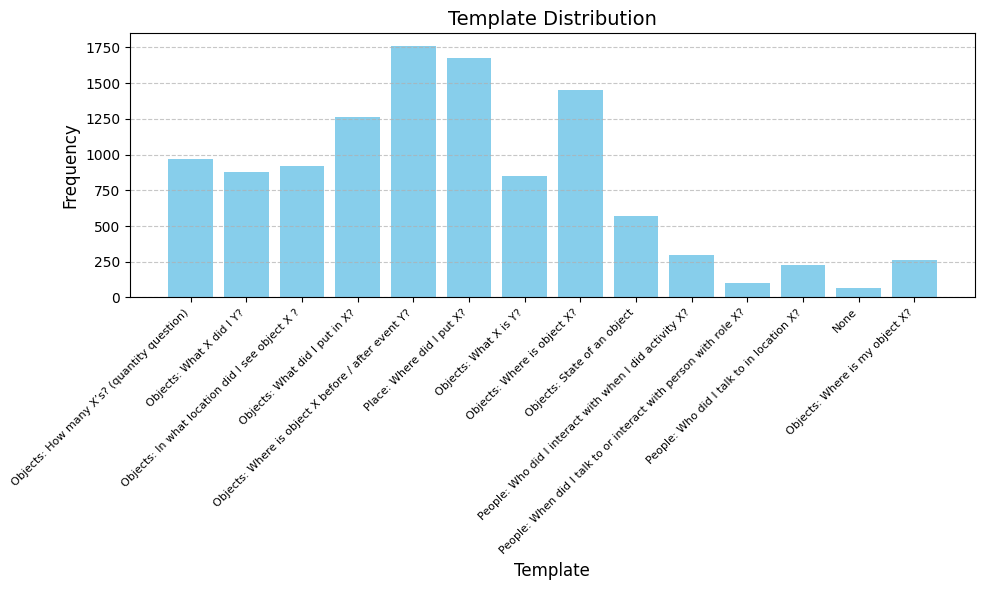

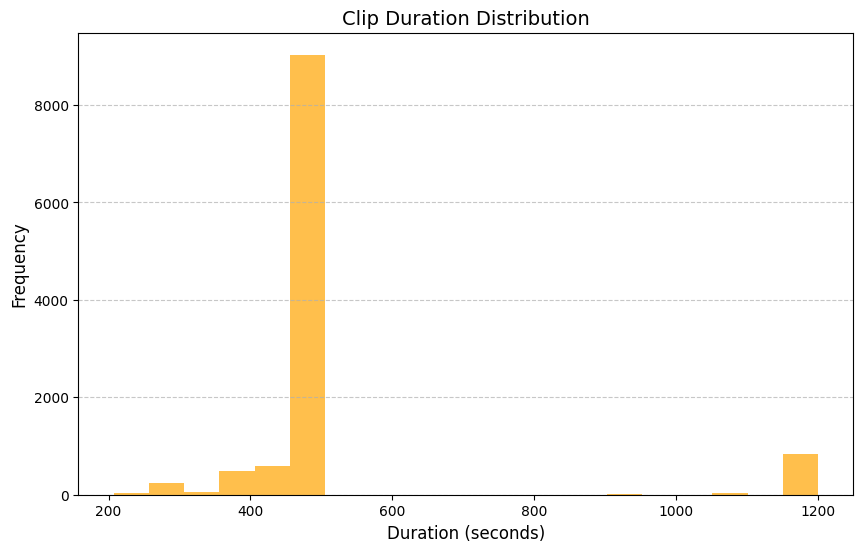


=== Statistics on Clip durations ===
    Average Clip duration: 522.68 seconds
    Max Clip duration: 1200.07 seconds
    Min Clip duration: 207.17 seconds
    Standard deviation of Clip duration: 197.64 seconds
    Median Clip duration: 480.00 seconds






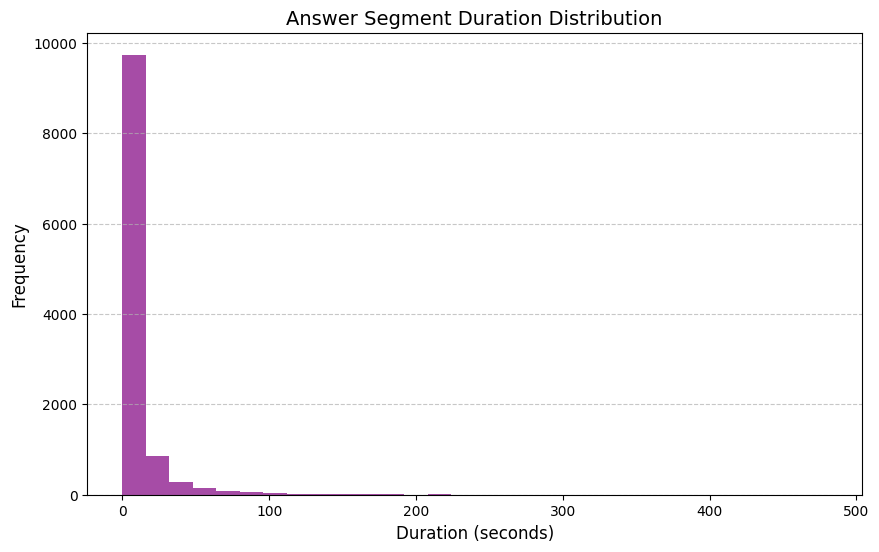


=== Statistics on Answer segment duration ===
    Average Answer segment duration: 9.67 seconds
    Max Answer segment duration: 480.00 seconds
    Min Answer segment duration: 0.00 seconds
    Standard deviation of Answer segment duration: 22.83 seconds
    Median Answer segment duration: 3.45 seconds






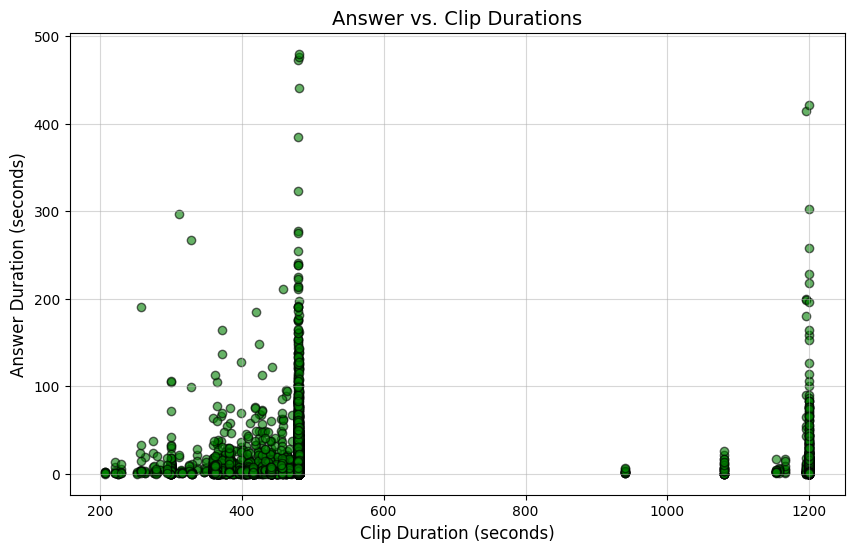

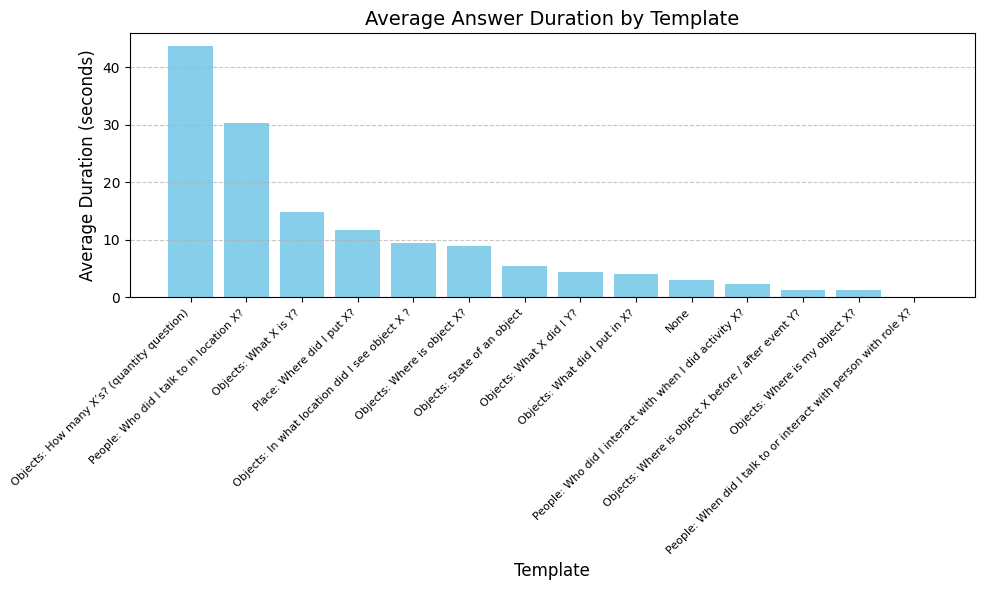

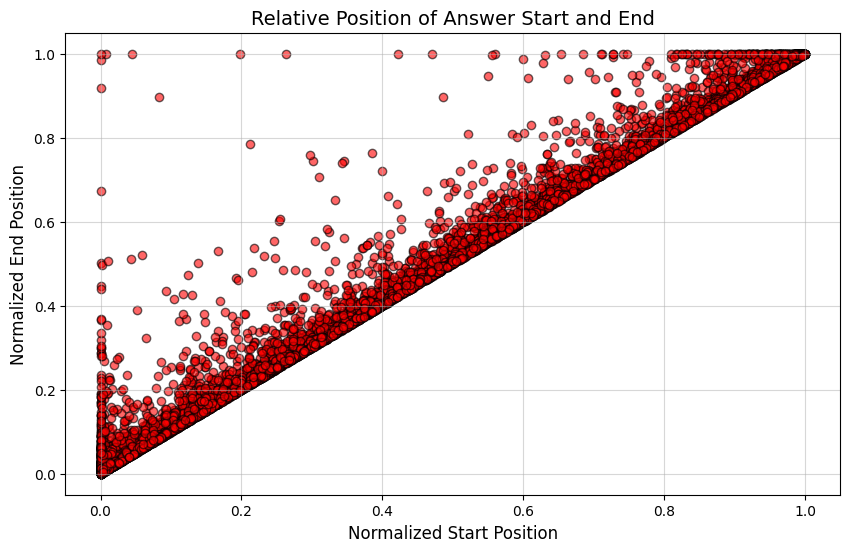

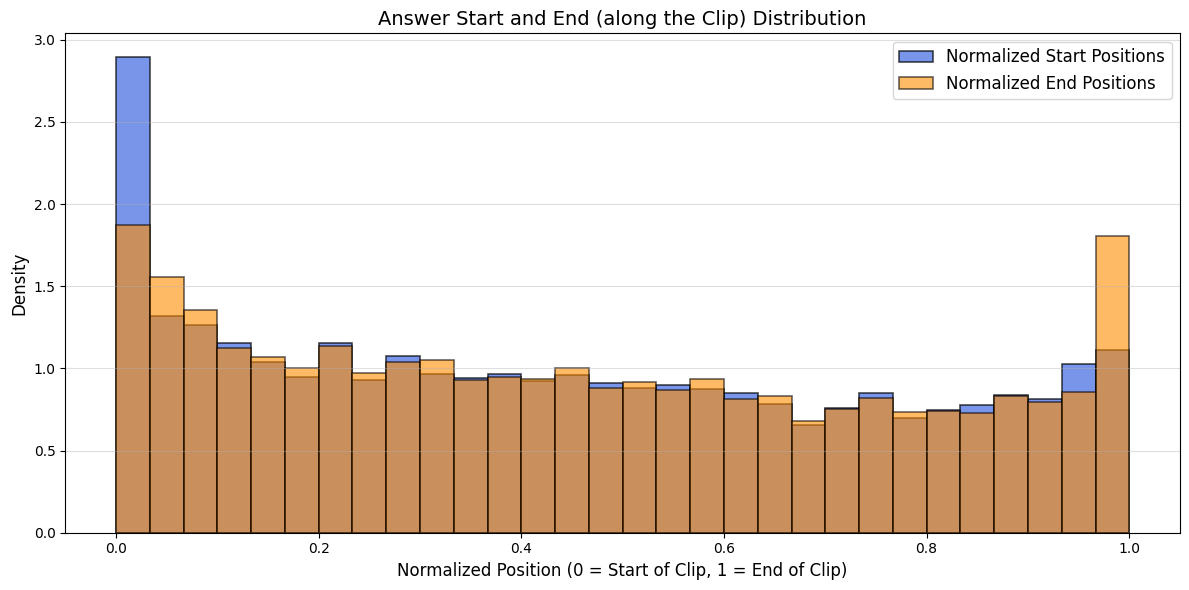

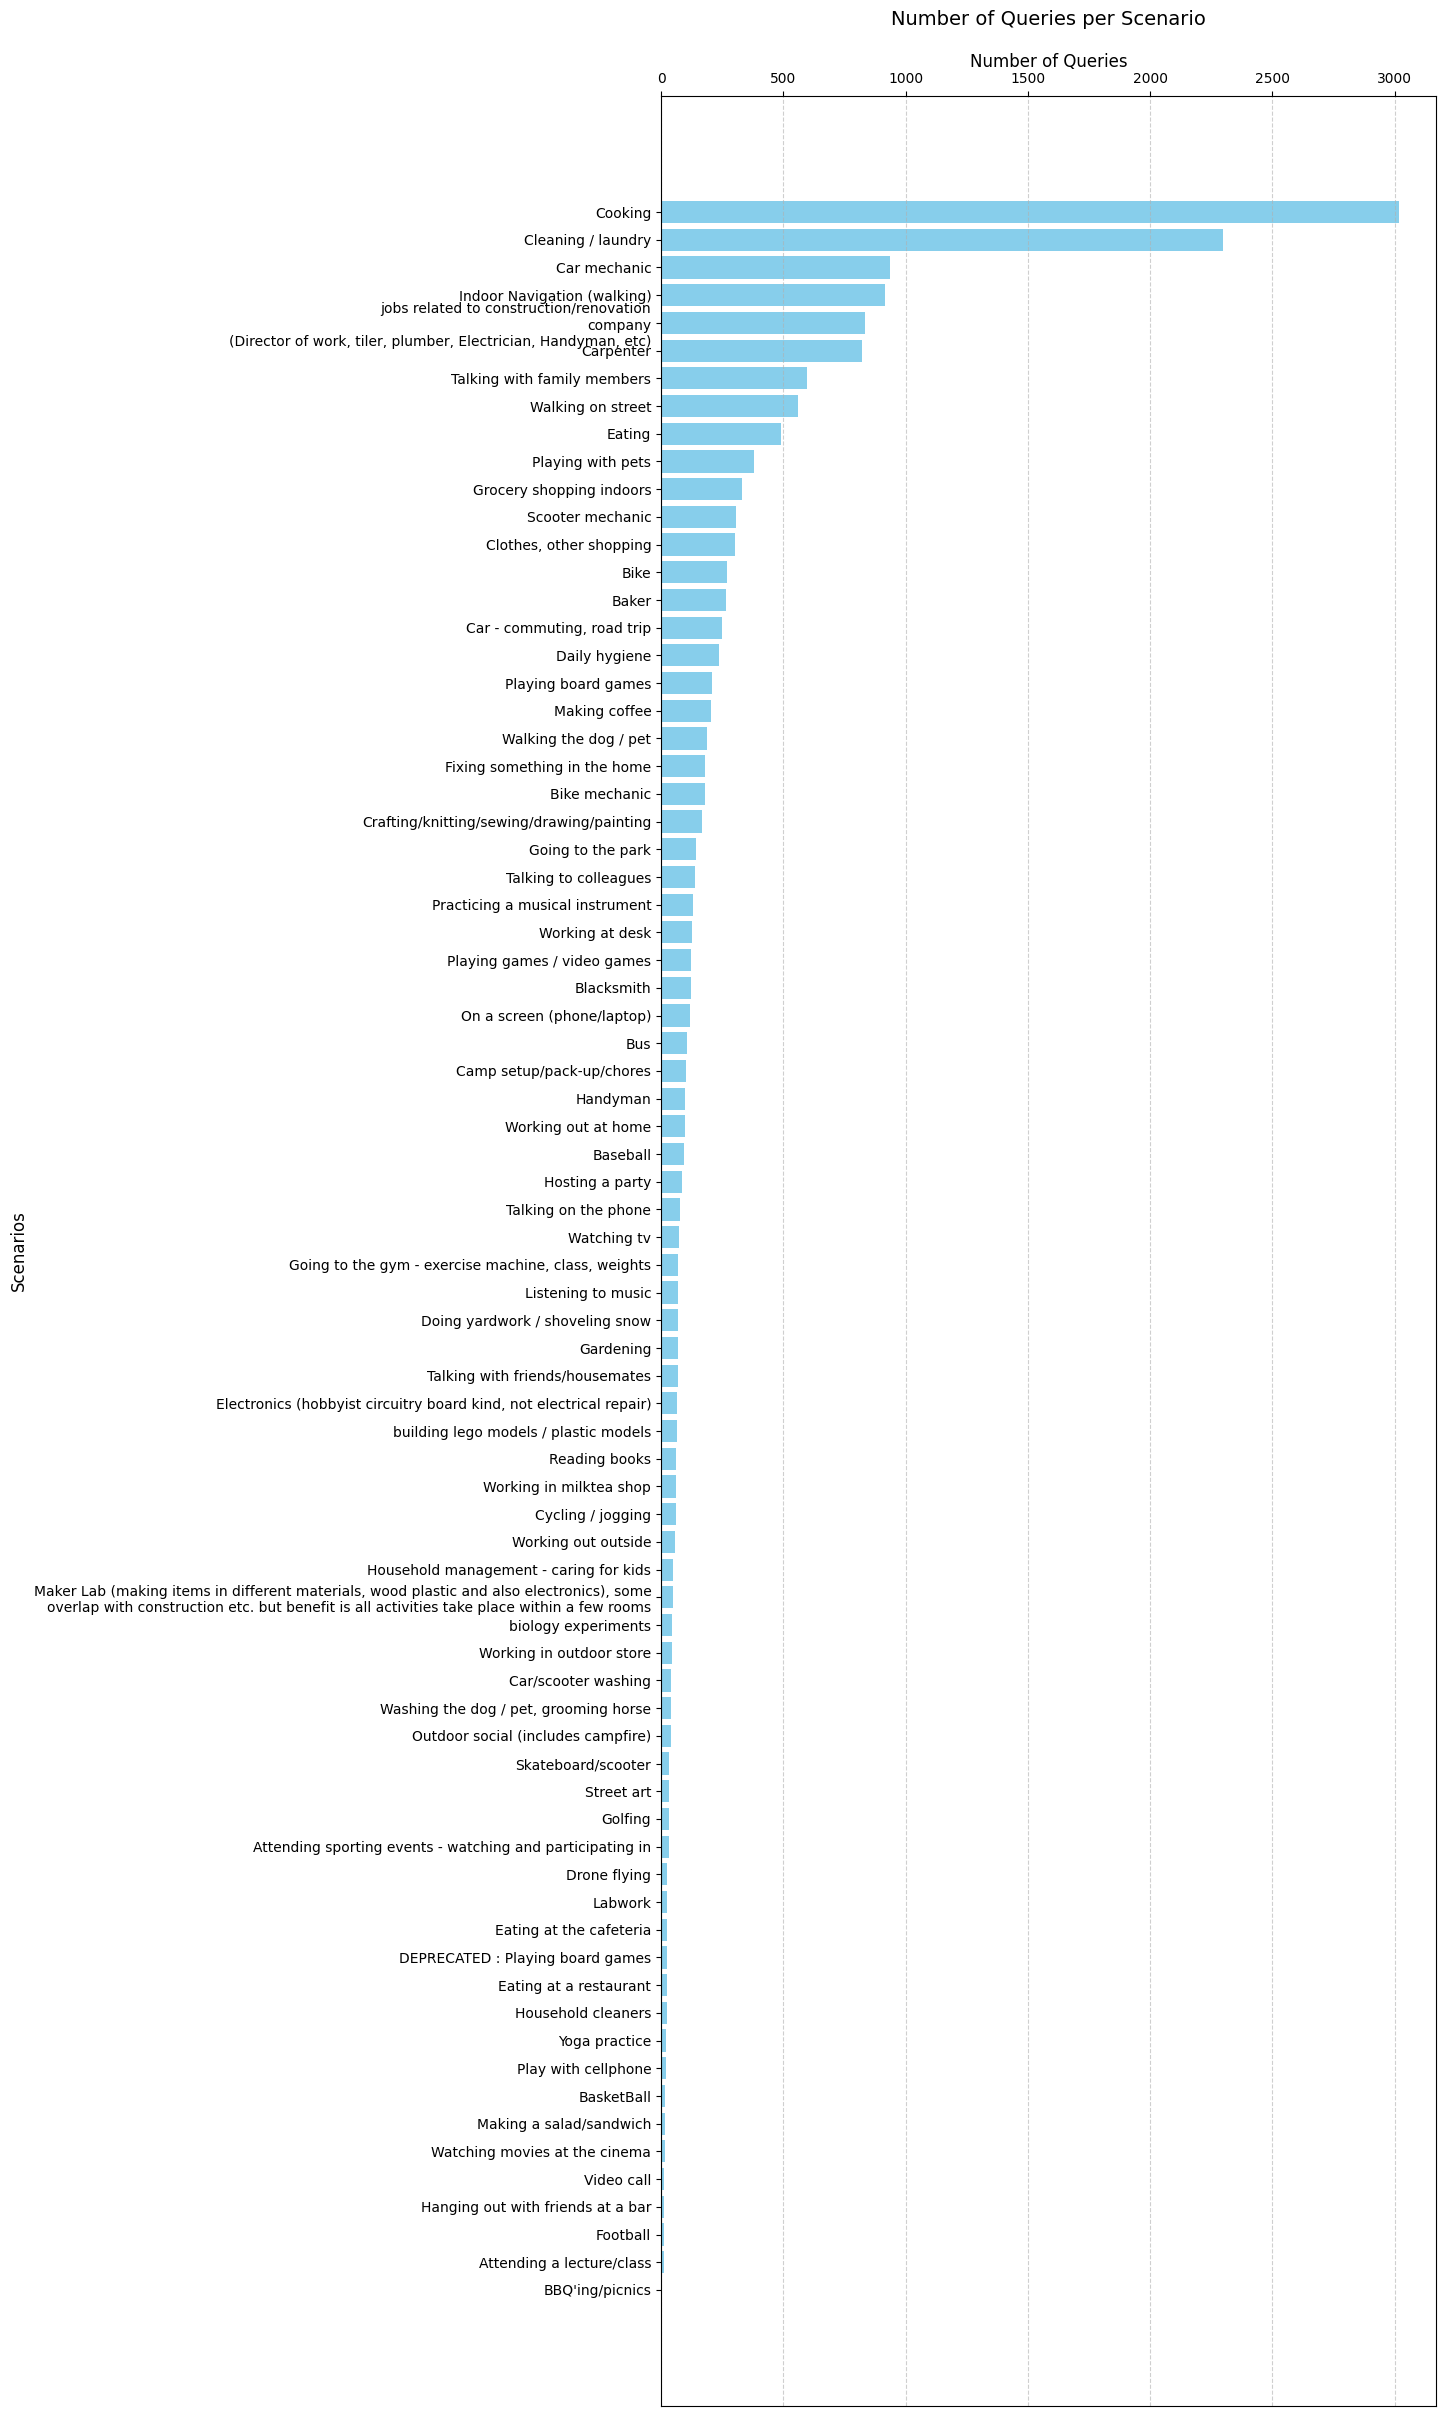


=== Statistics on Query counts across scenarios ===
    Average Query count: 223.99
    Max Query count: 3018
    Min Query count: 4
    Standard deviation of Query count: 455.08
    Median Query count: 73.0






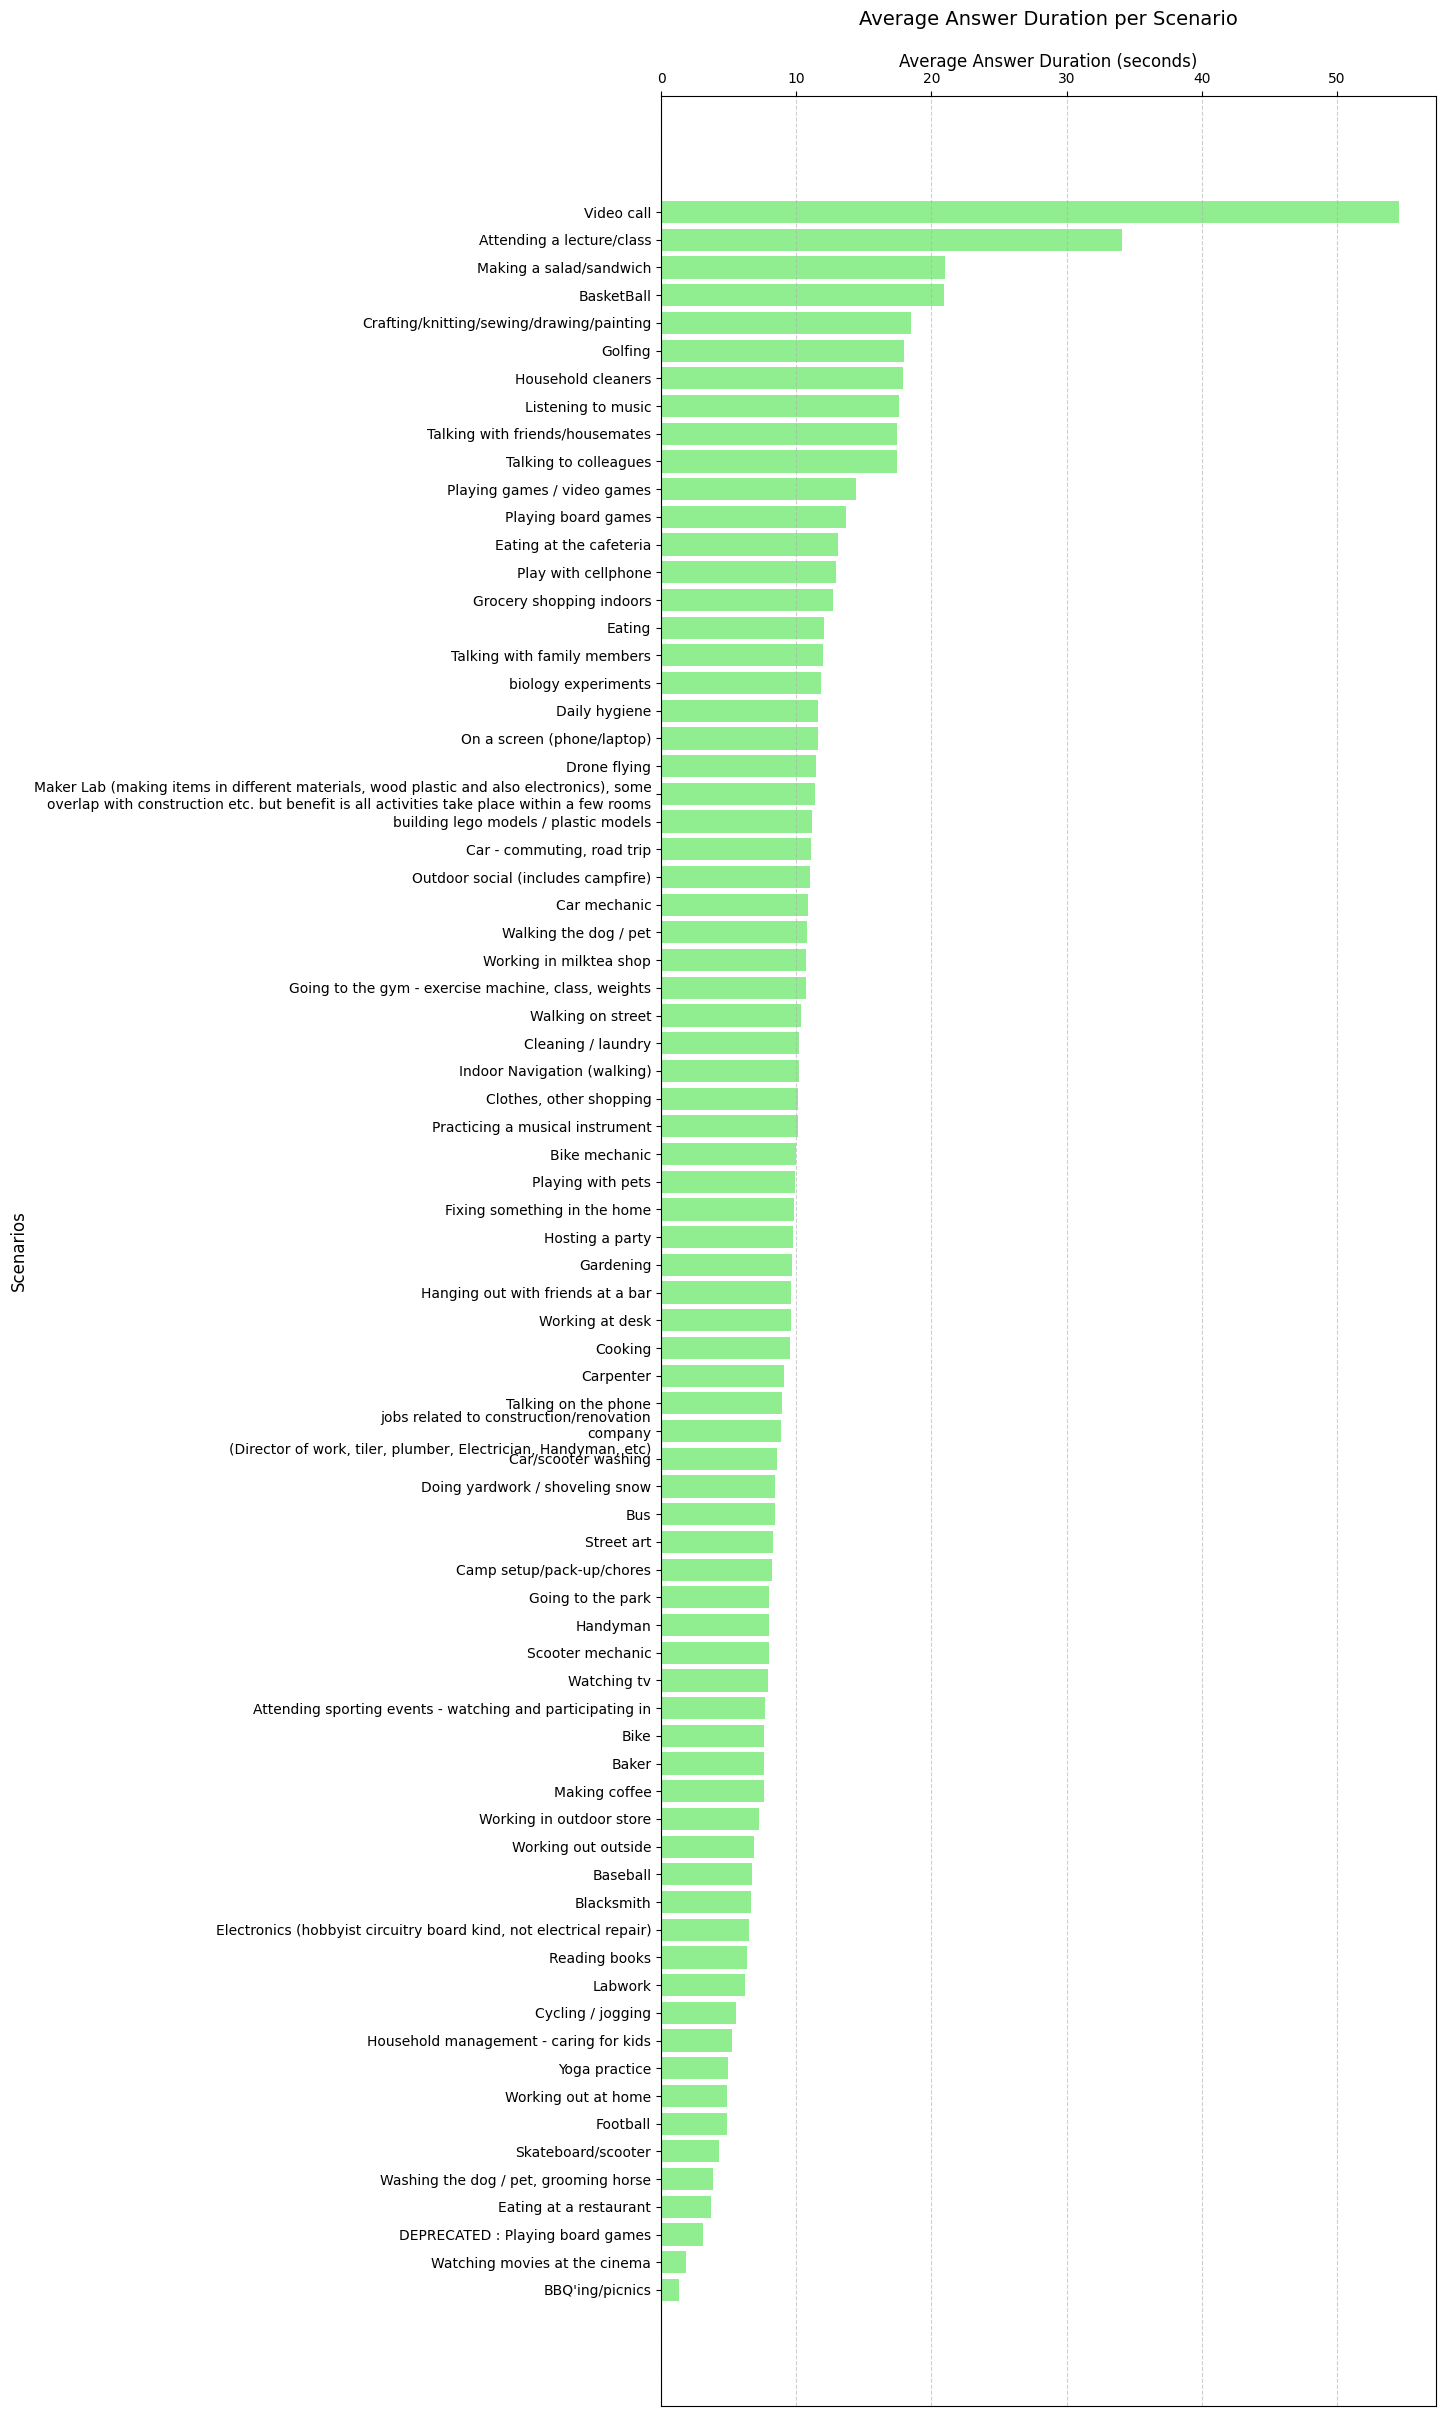


=== Statistics on Answer durations across scenarios ===
    Average Answer duration: 10.69 seconds
    Max Answer duration: 54.58 seconds
    Min Answer duration: 1.32 seconds
    Standard deviation of Answer duration: 7.05 seconds
    Median Answer duration: 9.72 seconds






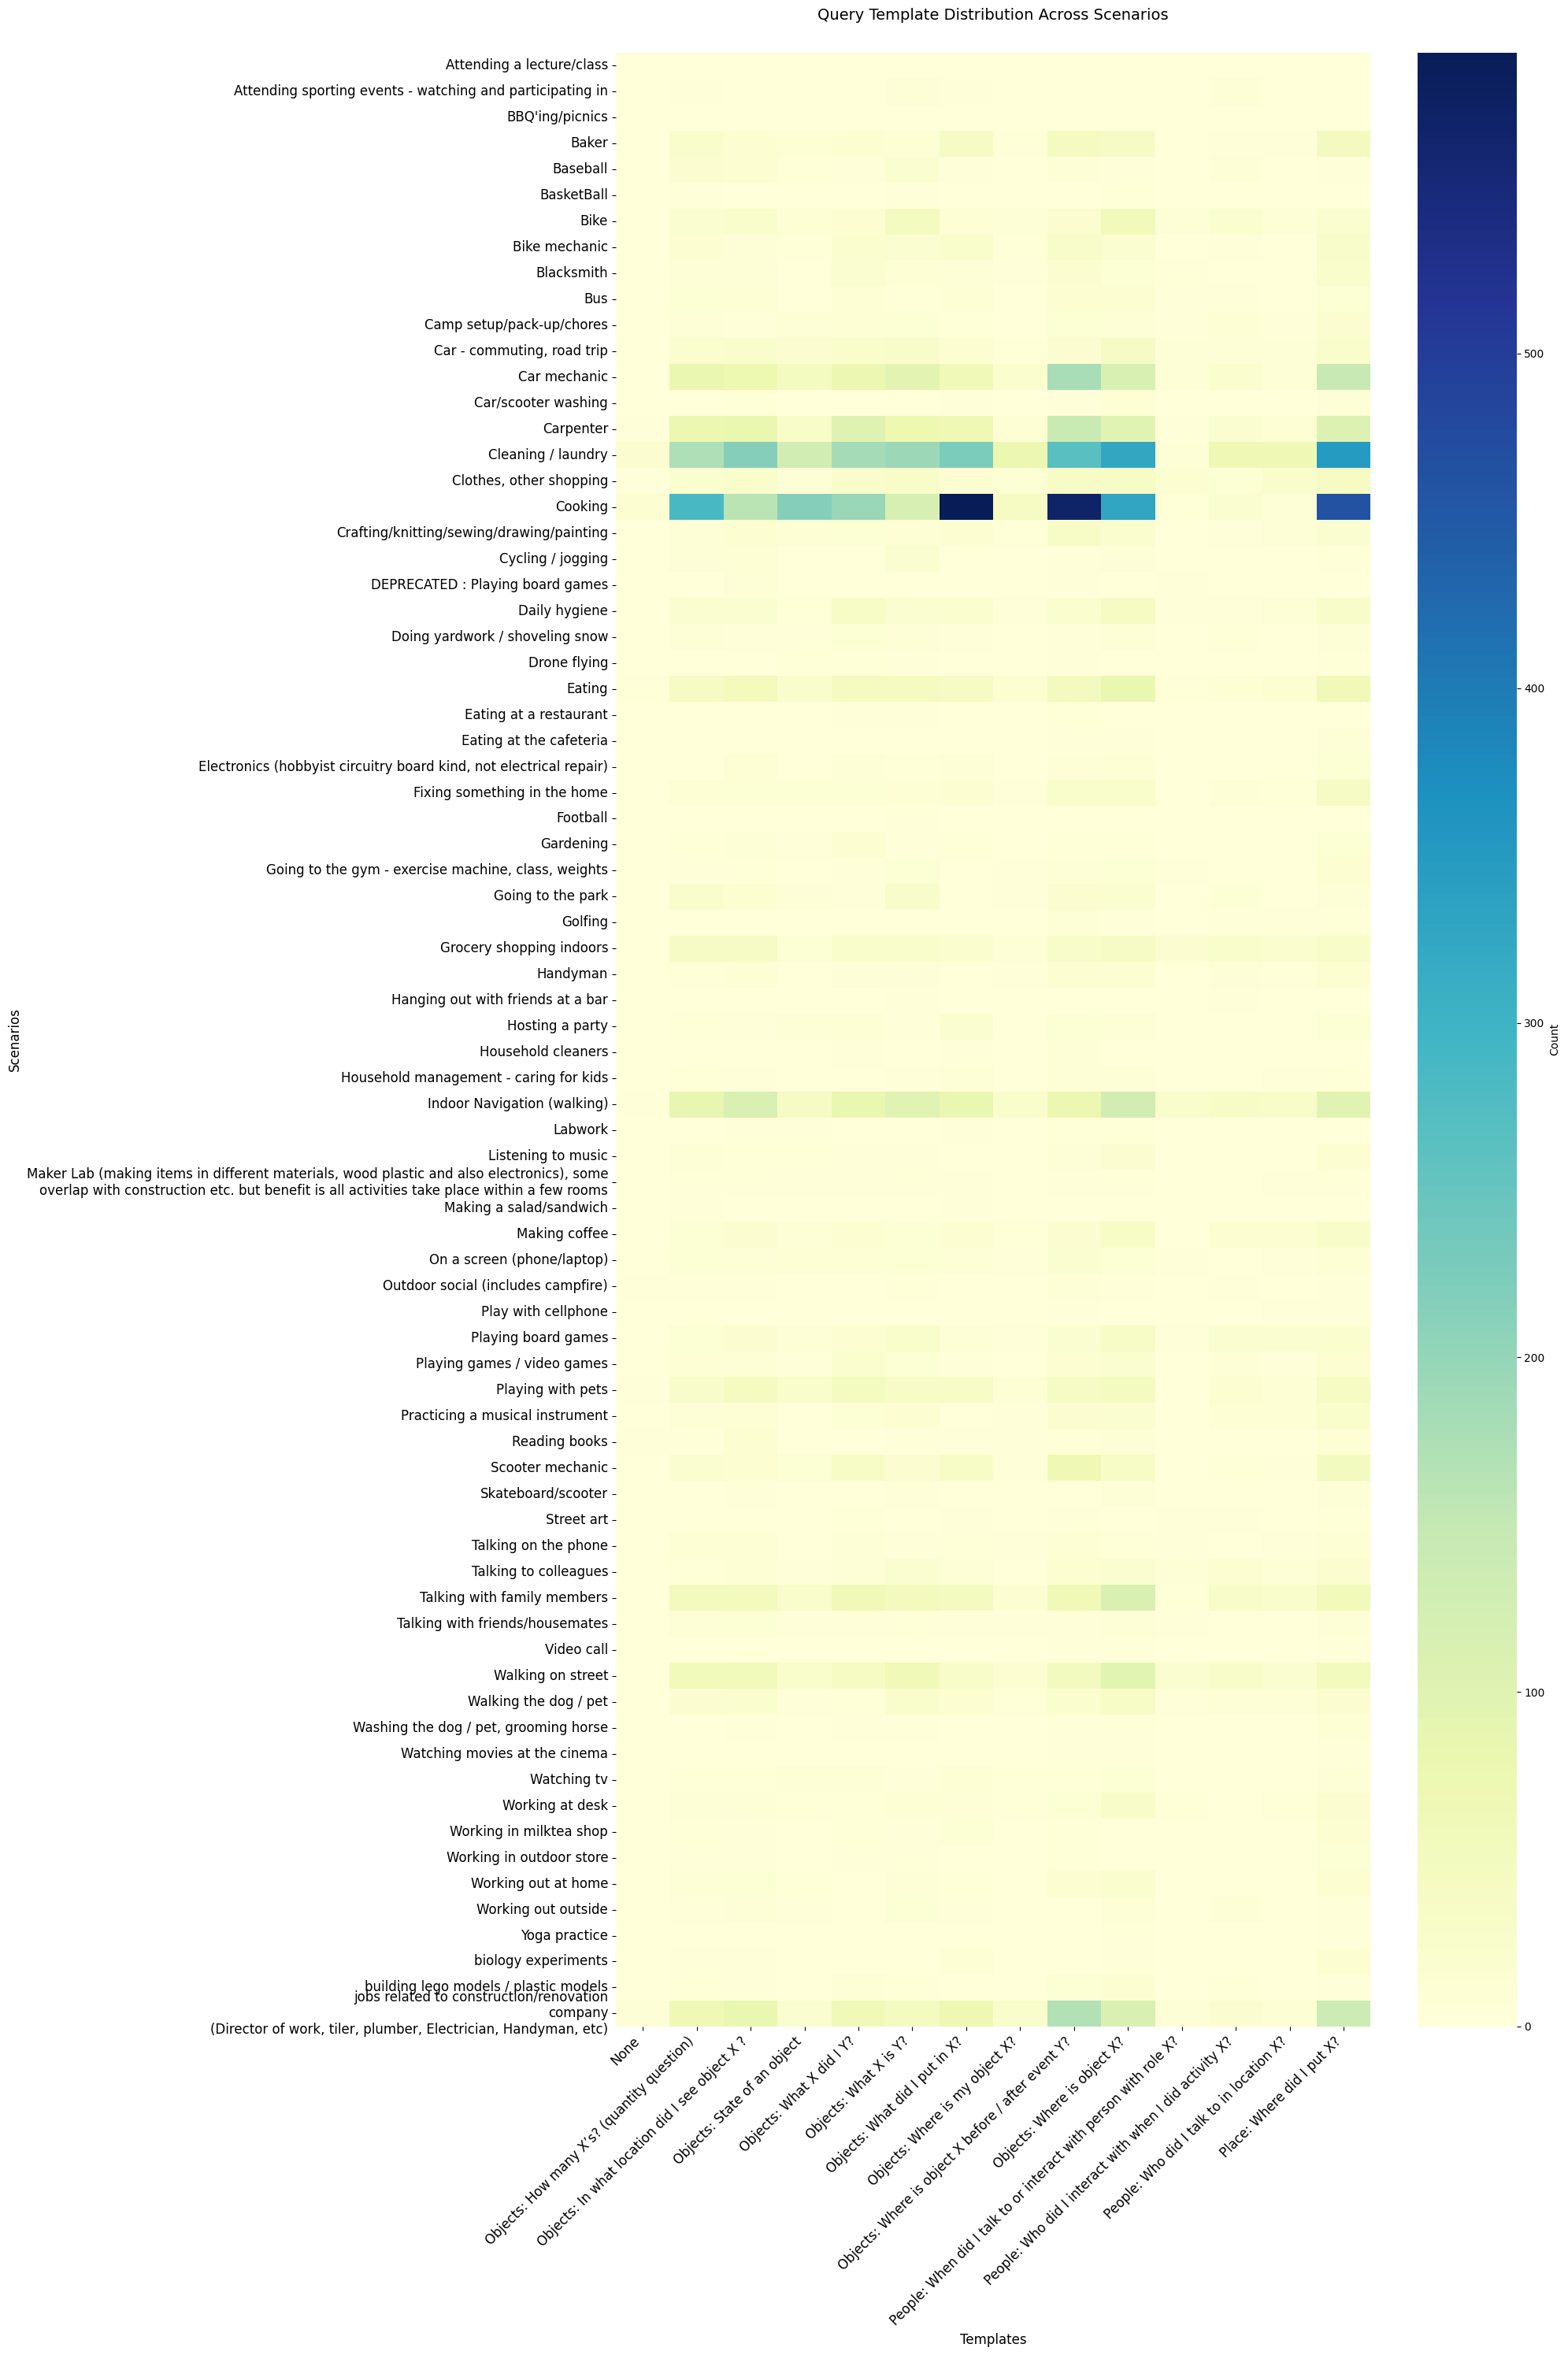

In [ ]:
"""1. TEMPLATE DISTRIBUTION"""
# Plot template distribution
plt.figure(figsize=(10, 6))
plt.bar(template_distribution.keys(), template_distribution.values(), color="skyblue")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.title("Template Distribution", fontsize=14)
plt.xlabel("Template", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()
print("\n" * 3)


"""2. CLIP DURATION DISTRIBUTION"""
# Plot clip duration distribution
plt.figure(figsize=(10, 6))
plt.hist(clip_durations, bins=20, color="orange", alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Clip Duration Distribution", fontsize=14)
plt.xlabel("Duration (seconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()
# Stats on clip duration
clip_durations = np.array(clip_durations) #create numpy array to check for stats like mean, min, max, std, median
print("\n=== Statistics on Clip durations ===")
print(f"    Average Clip duration: {clip_durations.mean():.2f} seconds")
print(f"    Max Clip duration: {clip_durations.max():.2f} seconds")
print(f"    Min Clip duration: {clip_durations.min():.2f} seconds")
print(f"    Standard deviation of Clip duration: {clip_durations.std():.2f} seconds")
print(f"    Median Clip duration: {np.median(clip_durations):.2f} seconds")
print("=" * 60)
print("\n" * 3)


"""3. ANSWER SEGMENT DURATION DISTRIBUTION"""
# Plot answer segment duration distribution
plt.figure(figsize=(10, 6))
plt.hist(answer_durations, bins=30, color="purple", alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Answer Segment Duration Distribution", fontsize=14)
plt.xlabel("Duration (seconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()
# Stats on answer segment duration
answer_durations = np.array(answer_durations) #create numpy array to check for stats like mean, min, max, std, median
print("\n=== Statistics on Answer segment duration ===")
print(f"    Average Answer segment duration: {answer_durations.mean():.2f} seconds")
print(f"    Max Answer segment duration: {answer_durations.max():.2f} seconds")
print(f"    Min Answer segment duration: {answer_durations.min():.2f} seconds")
print(f"    Standard deviation of Answer segment duration: {answer_durations.std():.2f} seconds")
print(f"    Median Answer segment duration: {np.median(answer_durations):.2f} seconds")
print("=" * 60)
print("\n" * 3)


"""4. ANSWER VS. CLIP DURATIONs"""
plt.figure(figsize=(10, 6))
plt.scatter(clip_durations, answer_durations, alpha=0.6, color="green", edgecolor="k")
plt.title("Answer vs. Clip Durations", fontsize=14)
plt.xlabel("Clip Duration (seconds)", fontsize=12)
plt.ylabel("Answer Duration (seconds)", fontsize=12)
plt.grid(alpha=0.5)
plt.show()
print("\n" * 3)


"""5. AVERAGE ANSWER DURATION BY TEMPLATE"""
# Calculate the duration for each template
template_durations = {}
for template, duration in zip(template_distribution.keys(), answer_durations):
    if template not in template_durations:
        template_durations[template] = []
    template_durations[template].append(duration)
# Calculate average duration for each template
avg_template_durations = {k: np.mean(v) for k, v in template_durations.items()}
# Sort templates by their average duration (in descending order)
sorted_template_durations = sorted(avg_template_durations.items(), key=lambda x: x[1], reverse=True)

# Plot all templates
plt.figure(figsize=(10, 6))
plt.bar([t[0] for t in sorted_template_durations], [t[1] for t in sorted_template_durations], color="skyblue")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha="right", fontsize=8)  # Rotate labels to fit them better
plt.title("Average Answer Duration by Template", fontsize=14)
plt.xlabel("Template", fontsize=12)
plt.ylabel("Average Duration (seconds)", fontsize=12)
plt.tight_layout()
plt.show()
print("\n" * 3)


"""6. RELATIVE POSITION OF ANSWER START AND END"""
# Plot normalized start and end positions (their relative position)
plt.figure(figsize=(10, 6))
plt.scatter(answer_start_positions, answer_end_positions, alpha=0.6, color="red", edgecolor="k")
plt.title("Relative Position of Answer Start and End", fontsize=14)
plt.xlabel("Normalized Start Position", fontsize=12)
plt.ylabel("Normalized End Position", fontsize=12)
plt.grid(alpha=0.5)
plt.show()
print("\n" * 3)


"""7. ANSWER START AND END (ALONG THE CLIP) DISTRIBUTION"""
# Plot distribution of start and end positions
plt.figure(figsize=(12, 6))
plt.hist(answer_start_positions, bins=30, density=True, color="royalblue", alpha=0.7, label="Normalized Start Positions", edgecolor="black", linewidth=1.2)
plt.hist(answer_end_positions, bins=30, density=True, color="darkorange", alpha=0.6, label="Normalized End Positions", edgecolor="black", linewidth=1.2)
plt.title("Answer Start and End (along the Clip) Distribution", fontsize=14)
plt.xlabel("Normalized Position (0 = Start of Clip, 1 = End of Clip)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()
print("\n" * 3)

"""8. NUMBER OF QUERIES PER SCENARIO"""
# Sort scenarios by query count
sorted_scenarios = sorted(scenario_query_counts.items(), key=lambda x: x[1], reverse=True)
scenarios, query_counts = zip(*sorted_scenarios)
# Plot query counts across scenarios
plt.figure(figsize=(10, 30))
plt.barh(scenarios, query_counts, color="skyblue")
plt.title("Number of Queries per Scenario", fontsize=14, pad=20)
plt.xlabel("Number of Queries", fontsize=12)
plt.ylabel("Scenarios", fontsize=12)
plt.gca().invert_yaxis() # Invert y-axis for better readability
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
# Stats on number of queries per scenario
print("\n=== Statistics on Query counts across scenarios ===")
print(f"    Average Query count: {np.mean(query_counts):.2f}")
print(f"    Max Query count: {max(query_counts)}")
print(f"    Min Query count: {min(query_counts)}")
print(f"    Standard deviation of Query count: {np.std(query_counts):.2f}")
print(f"    Median Query count: {np.median(query_counts)}")
print("=" * 60)
print("\n" * 3)


"""9. AVERAGE ANSWER DURATION PER SCENARIO"""
scenario_avg_durations = {k: np.mean(v) for k, v in scenario_durations.items() if v}
# Sort scenarios by average answer duration
sorted_scenarios = sorted(scenario_avg_durations.items(), key=lambda x: x[1], reverse=True)
scenarios, avg_answer_duration = zip(*sorted_scenarios)
#plot average anwer durations across scenarios
plt.figure(figsize=(10, 30))
plt.barh(scenarios, avg_answer_duration, color="lightgreen")
plt.xlabel("Average Answer Duration (seconds)", fontsize=12)
plt.ylabel("Scenarios", fontsize=12)
plt.title("Average Answer Duration per Scenario", fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
# Stats on answer duration per scenario
print("\n=== Statistics on Answer durations across scenarios ===")
print(f"    Average Answer duration: {np.mean(avg_answer_duration):.2f} seconds")
print(f"    Max Answer duration: {max(avg_answer_duration):.2f} seconds")
print(f"    Min Answer duration: {min(avg_answer_duration):.2f} seconds")
print(f"    Standard deviation of Answer duration: {np.std(avg_answer_duration):.2f} seconds")
print(f"    Median Answer duration: {np.median(avg_answer_duration):.2f} seconds")
print("=" * 60)
print("\n" * 3)


"""10. QUERY TEMPLATE DISTRIBUTION ACROSS SCENARIOS"""
# Convert nested dictionary into a plottable structure
scenario_template_summary = []
for scenario, templates in scenario_template_counts.items():
    for template, count in templates.items():
        scenario_template_summary.append({"Scenario": scenario, "Template": template, "Count": count})
# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(scenario_template_summary)
# Plot template counts per scenario as a heatmap
heatmap_data = df.pivot(index="Scenario", columns="Template", values="Count").fillna(0)
plt.figure(figsize=(20, 30))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Count'}, annot=False)
plt.title("Query Template Distribution Across Scenarios", fontsize=14, pad=30)
plt.xlabel("Templates", fontsize=12)
plt.ylabel("Scenarios", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### **Train, Validate and Test VSLNet using Omnivore features**



### Clone the Episodic Memory Baseline Repository

In [ ]:
%%bash
git clone https://github.com/EGO4D/episodic-memory
cd episodic-memory
git pull
git checkout nlq_fixes_and_fp16_support

Already up to date.
Branch 'nlq_fixes_and_fp16_support' set up to track remote branch 'nlq_fixes_and_fp16_support' from 'origin'.


Cloning into 'episodic-memory'...
Switched to a new branch 'nlq_fixes_and_fp16_support'


### Prepare input features

The NLQ baseline repository for VSLNet requires you to prepare the data for training and evaluation purposes. From the [README.md](https://github.com/EGO4D/episodic-memory/blob/main/NLQ/VSLNet/README.md#preparation) we need to run the `prepare_ego4d_dataset.py` script.

#### Download Omnivore features

The `omnivore_video_swinl_fp16` features were extracted by **Omnivore** model using temporal windows of 16 frames and temporal stride 16.

In [ ]:
# Download omnivore_video_swinl_fp16 features to ego4d_data/v1/omnivore_video_swinl_fp16 features
!ego4d --output_directory="/content/ego4d_data/" --datasets omnivore_video_swinl_fp16 --benchmarks nlq -y --version v1

#### Setup Environment Variables for NLQ

First let's setup some environment variables and setup the paths as NLQ's scripts will expect.

In [ ]:
with open("vars.sh", "w") as out_f:
  out_f.write("""
export NAME=omnivore_video_fp16
export TASK_NAME=nlq_official_v1_$NAME
export BASE_DIR=data/dataset/nlq_official_v1_$NAME
export FEATURE_BASE_DIR=data/features/nlq_official_v1_$NAME/
export FEATURE_DIR=$FEATURE_BASE_DIR/video_features
export MODEL_BASE_DIR=/content/nlq_official_v1/checkpoints/

cd episodic-memory/NLQ/VSLNet
"""
  )

In [ ]:
%%bash

source vars.sh

echo $FEATURE_BASE_DIR
mkdir -p $FEATURE_BASE_DIR
ln -s /content/ego4d_data/v1/omnivore_video_swinl_fp16 $FEATURE_DIR

data/features/nlq_official_v1_omnivore_video_fp16/


In [ ]:
%%bash
%%capture

source vars.sh
pip install nltk submitit torch torchaudio torchvision tqdm transformers tensorboard Pillow terminaltables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 5.7 MB/s eta 0:00:00


bash: line 1: fg: no job control


### Run the Prepare Script

This script will take a while to run and may not output progress until it is done. Please be patient.

In [ ]:
%%bash

source vars.sh

python utils/prepare_ego4d_dataset.py \
    --input_train_split /content/ego4d_data/v1/annotations/nlq_train.json \
    --input_val_split /content/ego4d_data/v1/annotations/nlq_val.json \
    --input_test_split /content/ego4d_data/v1/annotations/nlq_test_unannotated.json \
    --video_feature_read_path $FEATURE_DIR \
    --clip_feature_save_path $FEATURE_BASE_DIR/official \
    --output_save_path $BASE_DIR

Reading [train]: /content/ego4d_data/v1/annotations/nlq_train.json
# train: 11291
Writing [train]: data/dataset/nlq_official_v1_omnivore_video_fp16/train.json
Reading [val]: /content/ego4d_data/v1/annotations/nlq_val.json
# val: 3874
Writing [val]: data/dataset/nlq_official_v1_omnivore_video_fp16/val.json
Reading [test]: /content/ego4d_data/v1/annotations/nlq_test_unannotated.json
# test: 4004
Writing [test]: data/dataset/nlq_official_v1_omnivore_video_fp16/test.json


Extracting features:   0%|          | 0/1659 [00:00<?, ?it/s]/content/episodic-memory/NLQ/VSLNet/utils/prepare_ego4d_dataset.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

### Train and Validate the model

In [ ]:
!mkdir -p /content/episodic-memory/NLQ/VSLNet/runs/

In [ ]:
%%bash

source vars.sh

# machine parameters
export DATALOADER_WORKERS=1
export NUM_WORKERS=2
export VAL_JSON_PATH="/content/ego4d_data/v1/annotations/nlq_val.json"

# hyper parameters
export BATCH_SIZE=32
export DIM=128
export NUM_EPOCH=1
export MAX_POS_LEN=128
export INIT_LR=0.0025

export TB_LOG_NAME="${NAME}_bs${BATCH_SIZE}_dim${DIM}_epoch${NUM_EPOCH}_ilr${INIT_LR}"

python main.py \
    --task $TASK_NAME \
    --predictor bert \
    --dim $DIM \
    --mode train \
    --video_feature_dim 1536 \
    --max_pos_len $MAX_POS_LEN \
    --init_lr $INIT_LR \
    --epochs $NUM_EPOCH \
    --batch_size $BATCH_SIZE \
    --fv official \
    --num_workers $NUM_WORKERS \
    --data_loader_workers $DATALOADER_WORKERS \
    --model_dir $MODEL_BASE_DIR/$NAME \
    --eval_gt_json $VAL_JSON_PATH \
    --log_to_tensorboard $TB_LOG_NAME \
    --tb_log_freq 5 \
    --remove_empty_queries_from train

Running with Namespace(save_dir='datasets', task='nlq_official_v1_omnivore_video_fp16', eval_gt_json='/content/ego4d_data/v1/annotations/nlq_val.json', fv='official', max_pos_len=128, num_workers=2, data_loader_workers=1, word_size=None, char_size=None, word_dim=300, video_feature_dim=1536, char_dim=50, dim=128, highlight_lambda=5.0, num_heads=8, drop_rate=0.2, predictor='bert', gpu_idx='0', seed=12345, mode='train', epochs=1, batch_size=32, num_train_steps=None, init_lr=0.0025, clip_norm=1.0, warmup_proportion=0.0, extend=0.1, period=100, text_agnostic=False, video_agnostic=False, model_dir='/content/nlq_official_v1/checkpoints//omnivore_video_fp16', model_name='vslnet', suffix=None, log_to_tensorboard='omnivore_video_fp16_bs32_dim128_epoch1_ilr0.0025', tb_log_dir='./runs', tb_log_freq=5, slurm=False, slurm_wait=False, slurm_partition='pixar', slurm_constraint='volta', slurm_gpus=1, slurm_cpus=10, slurm_timeout_min=720, slurm_log_folder='slurm_log', remove_empty_queries_from=['train']

2024-12-11 18:56:27.722119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 18:56:27.742961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 18:56:27.749055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 18:56:27.764170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 18:56:29.035054: W tensorflow/compiler/tf2

### Test the model

In [ ]:
%%bash

source vars.sh


# hyper parameters
export MAX_POS_LEN=128


# To predict on test set.
python main.py \
    --task $TASK_NAME \
    --predictor bert \
    --mode test \
    --video_feature_dim 1536 \
    --max_pos_len $MAX_POS_LEN \
    --fv official \
    --model_dir $MODEL_BASE_DIR/$NAME

### Additionally

In [ ]:
%%bash

source vars.sh

# To evaluate predictions using official evaluation script.
PRED_FILE="/content/nlq_official_v1/checkpoints/omnivore_video_fp16/vslnet_nlq_official_v1_omnivore_video_fp16_official_128_bert/model"

python utils/evaluate_ego4d_nlq.py \
    --ground_truth_json /content/ego4d_data/v1/annotations/nlq_val.json \
    --model_prediction_json ${PRED_FILE}/vslnet_0_323_preds.json \
    --thresholds 0.3 0.5 \
    --topK 1 3 5

### **Train, Validate and Test VSLNet using EgoVLP features**



#### Download EgoVLP features

The `egovlp_fp16` features were extracted by **EgoVLP** model using temporal windows of 16 frames and temporal stride 16.

In [5]:
!wget https://drive.google.com/file/d/1U318S34jw3uNnsURJ1T40YwsSuK5_-RJ/view
!tar zxf egovlp_fp16.tar.gz

--2024-12-12 02:58:21--  https://drive.google.com/file/d/1U318S34jw3uNnsURJ1T40YwsSuK5_-RJ/view
Resolving drive.google.com (drive.google.com)... 142.250.107.138, 142.250.107.139, 142.250.107.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.107.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view’

view                    [ <=>                ]  91.25K  --.-KB/s    in 0.005s  

2024-12-12 02:58:21 (16.5 MB/s) - ‘view’ saved [93437]

tar (child): egovlp_fp16.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
